In [11]:
import anndata as ad
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.decomposition import PCA
from scipy.stats import spearmanr

sns.set_style("whitegrid")

In [ ]:
# adata_full = ad.read_h5ad(FILE := "out/results/GAT_2024-05-23-16-24-07_results.h5ad")
adata = ad.read_h5ad(FILE := "out/results/NoGraph_2025-06-18-14-45-40_results.h5ad")

In [22]:
FOLD = 0

In [30]:
adata.obs

,projid,Supertype,Donor ID,cell_type_high_resolution,study,scaled_to,agreeableness,conscientiousness,extraversion_6,neo_altruism,...,total_counts,total_counts_mt,pct_counts_mt,y,all,train_donor_f0,test_donor_f0,Celltype,scAGG_score_major,scAGG_score_minor
AAAGATGGTCGCTTTC-5-0-4,20207013,Astrocytes,20207013,Ast GRM3,ROS,ROSMAP,36.0,31.0,15.0,NaN,...,3089.000000,6.000000,0.194238,0.0,4,True,False,Astrocytes,-0.748947,NaN
AAGACCTGTTATTCTC-5-0-4,20207013,Astrocytes,20207013,Ast DPP10,ROS,ROSMAP,36.0,31.0,15.0,NaN,...,5800.000000,8.000000,0.137931,0.0,4,True,False,Astrocytes,0.568262,NaN
AATCCAGCAGACGCCT-5-0-4,20207013,Astrocytes,20207013,Ast GRM3,ROS,ROSMAP,36.0,31.0,15.0,NaN,...,3792.000000,3.000000,0.079114,0.0,4,True,False,Astrocytes,0.462969,NaN
AATCGGTAGGACGAAA-5-0-4,20207013,Astrocytes,20207013,Ast GRM3,ROS,ROSMAP,36.0,31.0,15.0,NaN,...,2068.000000,17.000000,0.822050,0.0,4,True,False,Astrocytes,-0.856218,NaN
ACACCAAGTCCCTTGT-5-0-4,20207013,Astrocytes,20207013,Ast GRM3,ROS,ROSMAP,36.0,31.0,15.0,NaN,...,4149.000000,12.000000,0.289226,0.0,4,True,False,Astrocytes,-0.642181,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CATTCCGAGCGACCCT-16-14-426,41285665,Vasculature_cells,41285665,Per,MAP,ROSMAP,NaN,34.0,14.0,22.0,...,3705.540104,27.818420,0.750725,0.0,426,True,False,Vasculature cells,1.436406,NaN
CGAAGGACAACGAGGT-16-14-426,41285665,Vasculature_cells,41285665,Per,MAP,ROSMAP,NaN,34.0,14.0,22.0,...,2238.762409,13.509120,0.603419,0.0,426,True,False,Vasculature cells,-0.116870,NaN
CTAGACAAGCCACCGT-16-14-426,41285665,Vasculature_cells,41285665,End,MAP,ROSMAP,NaN,34.0,14.0,22.0,...,1232.090191,2.889145,0.234491,0.0,426,True,False,Vasculature cells,-0.072165,NaN
TTACGTTAGTAAACAC-16-14-426,41285665,Vasculature_cells,41285665,End,MAP,ROSMAP,NaN,34.0,14.0,22.0,...,1399.909411,14.219615,1.015753,0.0,426,True,False,Vasculature cells,-0.313225,NaN


In [21]:
adata.obs["Celltype"] = adata.obs["Supertype"].map({
    "Astrocytes": "Astrocytes",
    "Excitatory_neurons_set2": "Excitatory neurons",
    "Excitatory_neurons_set3": "Excitatory neurons",
    "Excitatory_neurons_set1": "Excitatory neurons",
    "Immune_cells": "Immune cells",
    "Inhibitory_neurons": "Inhibitory neurons",
    "Oligodendrocytes": "Oligodendrocytes",
    "OPCs": "OPCs",
    "Vasculature_cells": "Vasculature cells",
}) 

In [ ]:
adata.obs["scAGG_score_major"] = np.nan

# major celltypes
for celltype in tqdm(adata.obs["Celltype"].unique()):
    ct_mask = adata.obs["Celltype"] == celltype
    adata_ct = adata[ct_mask].copy()
    
    x_pca = PCA(n_components=5).fit_transform(adata_ct.obsm[f"h_2_f{FOLD}"])
    mean_pca1 = pd.DataFrame({
        "PCA1": x_pca[:, 0],
        "Label": adata_ct.obs["Label"].values
    }).groupby("Label", observed=True)["PCA1"].mean()
    
    if mean_pca1["CT"] > mean_pca1["AD"]:
        print("CT mean is higher than AD mean along 1st PC, so we flip the sign for the scores.")
        x_pca[:, 0] *= -1
        mean_pca1 *= -1
        
    if not (mean_pca1["CT"] < mean_pca1["Other"] and 
            mean_pca1["Other"] < mean_pca1["AD"]):
        print("CT -> Other -> AD order not satisfied in celltype:", celltype)
        print(mean_pca1)
        
    # standardize PCA scores for a "cell severity score"    
    adata.obs.loc[ct_mask, "scAGG_score_major"] = (x_pca[:, 0] - np.mean(x_pca[:, 0])) / np.std(x_pca[:, 0])
    


100%|██████████| 7/7 [00:25<00:00,  3.66s/it]


In [ ]:
adata.obs["scAGG_score_minor"] = np.nan

# minor cell types
for celltype in tqdm(adata.obs["cell_type_high_resolution"].unique()):
    ct_mask = adata.obs["cell_type_high_resolution"] == celltype
    adata_ct = adata[ct_mask].copy()
    
    x_pca = PCA(n_components=5).fit_transform(adata_ct.obsm[f"h_2_f{FOLD}"])
    mean_pca1 = pd.DataFrame({
        "PCA1": x_pca[:, 0],
        "Label": adata_ct.obs["Label"].values
    }).groupby("Label", observed=True)["PCA1"].mean()
    
    if mean_pca1["CT"] > mean_pca1["AD"]:
        # CT mean is higher than AD mean along 1st PC, so we flip the sign for the scores.
        x_pca[:, 0] *= -1
        mean_pca1 *= -1
        
    if not (mean_pca1["CT"] < mean_pca1["Other"] and 
            mean_pca1["Other"] < mean_pca1["AD"]):
        print("CT -> Other -> AD order not satisfied in celltype:", celltype)
        print(mean_pca1)
        
    # standardize PCA scores for a "cell severity score"    
    adata.obs.loc[ct_mask, "scAGG_score_minor"] = (x_pca[:, 0] - np.mean(x_pca[:, 0])) / np.std(x_pca[:, 0])

 11%|█         | 6/54 [00:08<01:14,  1.54s/it]

CT mean is higher than AD mean along 1st PC, so we flip the sign for the scores.


 15%|█▍        | 8/54 [00:09<00:52,  1.14s/it]

CT mean is higher than AD mean along 1st PC, so we flip the sign for the scores.


 17%|█▋        | 9/54 [00:10<00:39,  1.14it/s]

CT mean is higher than AD mean along 1st PC, so we flip the sign for the scores.


 20%|██        | 11/54 [00:11<00:28,  1.49it/s]

CT mean is higher than AD mean along 1st PC, so we flip the sign for the scores.


 30%|██▉       | 16/54 [00:12<00:09,  3.80it/s]

CT mean is higher than AD mean along 1st PC, so we flip the sign for the scores.


 31%|███▏      | 17/54 [00:12<00:12,  2.98it/s]

CT mean is higher than AD mean along 1st PC, so we flip the sign for the scores.


 39%|███▉      | 21/54 [00:13<00:08,  3.97it/s]

CT mean is higher than AD mean along 1st PC, so we flip the sign for the scores.


 46%|████▋     | 25/54 [00:14<00:07,  4.09it/s]

CT mean is higher than AD mean along 1st PC, so we flip the sign for the scores.


 50%|█████     | 27/54 [00:15<00:08,  3.25it/s]

CT mean is higher than AD mean along 1st PC, so we flip the sign for the scores.


 57%|█████▋    | 31/54 [00:16<00:04,  5.04it/s]

CT mean is higher than AD mean along 1st PC, so we flip the sign for the scores.


 65%|██████▍   | 35/54 [00:16<00:04,  4.63it/s]

CT mean is higher than AD mean along 1st PC, so we flip the sign for the scores.


 76%|███████▌  | 41/54 [00:17<00:01,  8.23it/s]

CT mean is higher than AD mean along 1st PC, so we flip the sign for the scores.
CT mean is higher than AD mean along 1st PC, so we flip the sign for the scores.


 83%|████████▎ | 45/54 [00:17<00:00,  9.85it/s]

CT mean is higher than AD mean along 1st PC, so we flip the sign for the scores.
CT mean is higher than AD mean along 1st PC, so we flip the sign for the scores.
CT mean is higher than AD mean along 1st PC, so we flip the sign for the scores.


 96%|█████████▋| 52/54 [00:26<00:01,  1.85it/s]

CT mean is higher than AD mean along 1st PC, so we flip the sign for the scores.
CT mean is higher than AD mean along 1st PC, so we flip the sign for the scores.


100%|██████████| 54/54 [00:26<00:00,  2.05it/s]


In [ ]:
DONORS = adata.obs["Donor ID"].unique()
CT_MAJ = adata.obs["Celltype"].unique()
CT_MIN = adata.obs["cell_type_high_resolution"].unique()

N_DONORS = len(DONORS)
N_CT_MAJ = len(CT_MAJ)
N_CT_MIN = len(CT_MIN)

mean_ct_score_major = np.zeros(shape=(N_DONORS, N_CT_MAJ))
mean_ct_score_minor = np.zeros(shape=(N_DONORS, N_CT_MIN))

# (very inefficient double for loop, but ok for now)
for i, donor in enumerate(tqdm(DONORS)):
    donor_mask = adata.obs["Donor ID"] == donor
    for j, celltype in enumerate(CT_MAJ):
        ct_mask = adata.obs["Celltype"] == celltype
        mean_ct_score_major[i, j] = adata.obs.loc[donor_mask & ct_mask, "scAGG_score_major"].mean()
        
    for j, celltype in enumerate(CT_MIN):
        ct_mask = adata.obs["cell_type_high_resolution"] == celltype
        mean_ct_score_minor[i, j] = adata.obs.loc[donor_mask & ct_mask, "scAGG_score_minor"].mean()

100%|██████████| 339/339 [07:49<00:00,  1.39s/it]


In [59]:
donor_pred_ys = adata.uns["y_pred_graph_f0"]
donor_y = np.zeros(shape=(N_DONORS))

for i, donor in enumerate(DONORS):
    donor_y[i] = donor_pred_ys[str(donor)][0, 1]

In [82]:
# and load the PRS scores from file, to sort using those
prs = pd.read_csv("data/PRS_FinnGen_by_projid.csv", index_col=0)

donors_with_prs = [donor for donor in DONORS if donor in prs.index]
print(len(donors_with_prs), len(DONORS))

donor_prs = np.zeros(shape=(len(donors_with_prs),))
for i, donor in enumerate(donors_with_prs):
    donor_prs[i] = prs.loc[donor, "PRS"]
    

312 339


In [111]:
donor_mask = np.isin(DONORS, donors_with_prs)
mean_ct_score_major_prs = mean_ct_score_major[donor_mask]
mean_ct_score_minor_prs = mean_ct_score_minor[donor_mask]
# sort by PRS
sorted_indices = np.arange(len(donor_prs))
mean_ct_score_major_prs = mean_ct_score_major_prs[sorted_indices]
mean_ct_score_minor_prs = mean_ct_score_minor_prs[sorted_indices]

# append PRS and y to the sorted arrays
mean_ct_score_major_prs = np.hstack((mean_ct_score_major_prs, donor_prs[sorted_indices, None], donor_y[donor_mask][sorted_indices, None]))
mean_ct_score_minor_prs = np.hstack((mean_ct_score_minor_prs, donor_prs[sorted_indices, None], donor_y[donor_mask][sorted_indices, None]))

xticks_major = CT_MAJ.tolist() + ["PRS", "y_pred"]
xticks_minor = CT_MIN.tolist() + ["PRS", "y_pred"]


In [132]:
# sort_by = donor_prs
sort_by = donor_y[donor_mask]
sort_by_text = "Predicted AD risk (y_pred)"
sorted_indices = np.argsort(sort_by)

major = mean_ct_score_major_prs[sorted_indices]
minor = mean_ct_score_minor_prs[sorted_indices]

Spearman correlation (with Predicted AD risk (y_pred)) for Astrocytes: 0.816, p-value: 1.278e-75
Spearman correlation (with Predicted AD risk (y_pred)) for Excitatory neurons: 0.957, p-value: 3.550e-169
Spearman correlation (with Predicted AD risk (y_pred)) for Immune cells: 0.662, p-value: 1.283e-40
Spearman correlation (with Predicted AD risk (y_pred)) for Inhibitory neurons: 0.911, p-value: 5.955e-121
Spearman correlation (with Predicted AD risk (y_pred)) for Oligodendrocytes: 0.841, p-value: 1.436e-84
Spearman correlation (with Predicted AD risk (y_pred)) for OPCs: 0.745, p-value: 1.639e-56
Spearman correlation (with Predicted AD risk (y_pred)) for Vasculature cells: 0.562, p-value: 2.234e-27


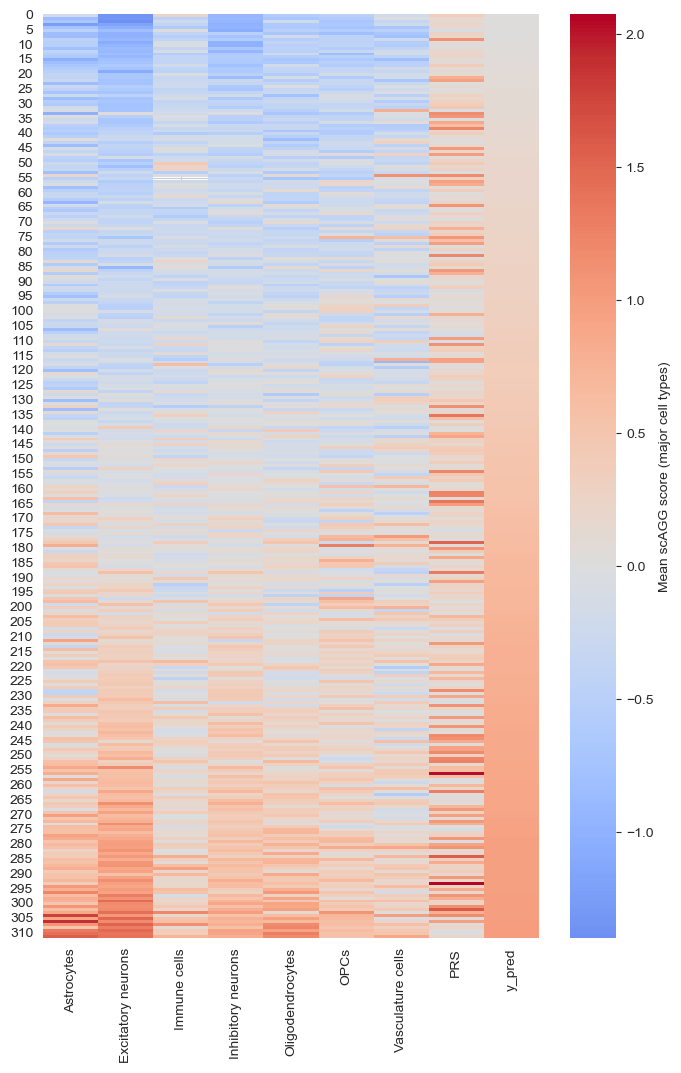

In [133]:
fig, ax = plt.subplots(figsize=(8, 12))
sns.heatmap(
    major,
    xticklabels=xticks_major,
    # yticklabels=donors_with_prs[np.argsort(donor_y)],
    cmap="coolwarm",
    center=0,
    cbar_kws={"label": "Mean scAGG score (major cell types)"},
    # annot=True,
    # fmt=".2f",
    ax=ax,
)

celltype_corrs_major = np.zeros(shape=(N_CT_MAJ,))

# and calculate the correlation between each of the columns and the donor_y
for j, celltype in enumerate(CT_MAJ):
    corr, pval = spearmanr(major[:, j], sort_by[sorted_indices], nan_policy='omit')
    print(f"Spearman correlation (with {sort_by_text}) for {celltype}: {corr:.3f}, p-value: {pval:.3e}")
    celltype_corrs_major[j] = corr
    
    # and pearson
    # corr = np.corrcoef(mean_ct_score_major_prs[:, j], donor_prs)[0, 1]
    # pval = np.corrcoef(mean_ct_score_major_prs[:, j], donor_prs)[1, 0]
    # print(f"Pearson correlation for {celltype}: {corr:.3f}, p-value: {pval:.3e}")

Spearman correlation (with Predicted AD risk (y_pred)) for Ast GRM3: 0.805, p-value: 6.127e-72
Spearman correlation (with Predicted AD risk (y_pred)) for Ast DPP10: 0.726, p-value: 4.789e-52
Spearman correlation (with Predicted AD risk (y_pred)) for Ast CHI3L1: 0.636, p-value: 4.562e-35
Spearman correlation (with Predicted AD risk (y_pred)) for Excitatory_neurons_set1: 0.952, p-value: 2.486e-161
Spearman correlation (with Predicted AD risk (y_pred)) for Exc L3-4 RORB CUX2: 0.934, p-value: 9.791e-141
Spearman correlation (with Predicted AD risk (y_pred)) for Exc L4-5 RORB GABRG1: 0.902, p-value: 7.635e-115
Spearman correlation (with Predicted AD risk (y_pred)) for Exc L4-5 RORB IL1RAPL2: 0.931, p-value: 3.774e-138
Spearman correlation (with Predicted AD risk (y_pred)) for Exc L3-5 RORB PLCH1: 0.904, p-value: 2.483e-116
Spearman correlation (with Predicted AD risk (y_pred)) for Exc L5-6 RORB LINC02196: 0.899, p-value: 7.755e-113
Spearman correlation (with Predicted AD risk (y_pred)) for 

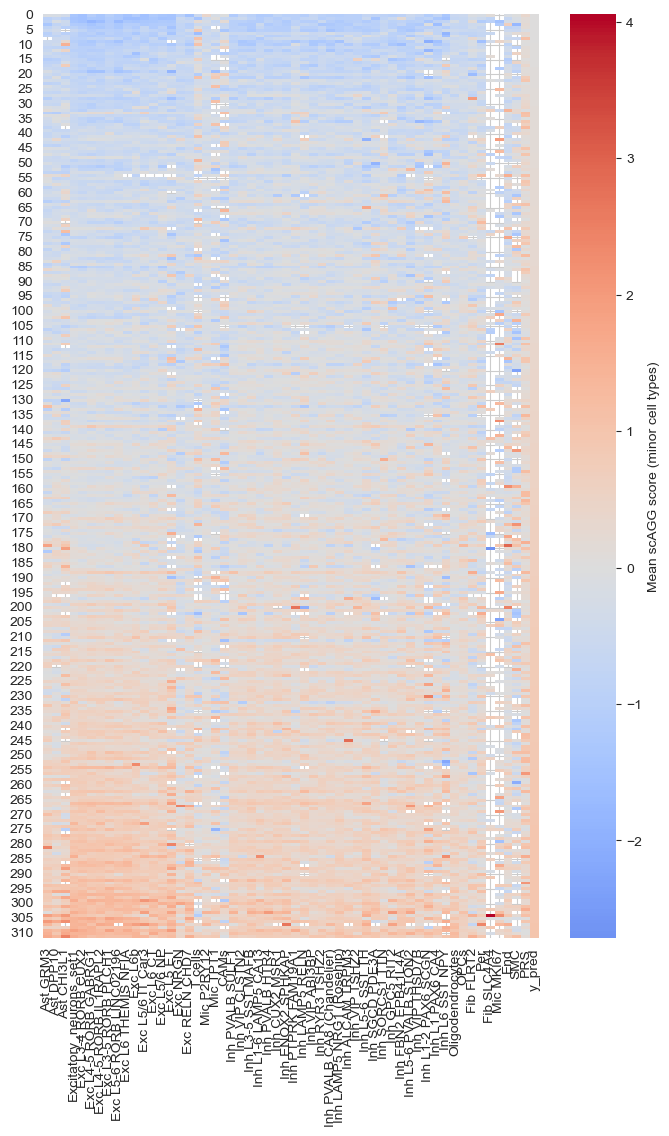

In [134]:
fig, ax = plt.subplots(figsize=(8, 12))
sns.heatmap(
    minor,
    xticklabels=xticks_minor,
    # yticklabels=donors_with_prs[np.argsort(donor_y)],
    cmap="coolwarm",
    center=0,
    cbar_kws={"label": "Mean scAGG score (minor cell types)"},
    # annot=True,
    # fmt=".2f",
    ax=ax,
)

celltype_corrs_minor = np.zeros(shape=(N_CT_MIN,))

# and calculate the correlation between each of the columns and the donor_y
for j, celltype in enumerate(CT_MIN):
    corr, pval = spearmanr(minor[:, j], sort_by[sorted_indices], nan_policy='omit')
    print(f"Spearman correlation (with {sort_by_text}) for {celltype}: {corr:.3f}, p-value: {pval:.3e}")
    
    celltype_corrs_minor[j] = corr
    # and pearson
    # corr = np.corrcoef(mean_ct_score_minor_prs[:, j], donor_prs)[0, 1]
    # pval = np.corrcoef(mean_ct_score_minor_prs[:, j], donor_prs)[1, 0]
    # print(f"Pearson correlation for {celltype}: {corr:.3f}, p-value: {pval:.3e}")

In [135]:
# for both, sort the celltypes by the correlation with the PRS

# also add their overall prevalence to the df

corrs_major = pd.DataFrame({
    "Correlation": celltype_corrs_major,
    "Abundance": adata.obs["Celltype"].value_counts().reindex(CT_MAJ, fill_value=0),
}, index=CT_MAJ)

corrs_minor = pd.DataFrame({
    "Correlation": celltype_corrs_minor,
    "Abundance": adata.obs["cell_type_high_resolution"].value_counts().reindex(CT_MIN, fill_value=0),
}, index=CT_MIN)

# sort
corrs_major = corrs_major.sort_values(by="Correlation", ascending=False)
corrs_minor = corrs_minor.sort_values(by="Correlation", ascending=False)

print(f"Major cell types correlation with {sort_by_text}:")
print(corrs_major)

print("")
print(f"Minor cell types correlation with {sort_by_text}:")
print(corrs_minor)


Major cell types correlation with Predicted AD risk (y_pred):
                    Correlation  Abundance
Excitatory neurons     0.957331     813827
Inhibitory neurons     0.910544     315692
Oligodendrocytes       0.840673     591853
Astrocytes             0.815533     136842
OPCs                   0.745265      83596
Immune cells           0.662194      78759
Vasculature cells      0.562029      16909

Minor cell types correlation with Predicted AD risk (y_pred):
                            Correlation  Abundance
Excitatory_neurons_set1        0.951926     257130
Exc L3-4 RORB CUX2             0.934126     149951
Exc L4-5 RORB IL1RAPL2         0.931453      95076
Exc L6 THEMIS NFIA             0.918046      56532
Exc L3-5 RORB PLCH1            0.903857      33209
Exc L4-5 RORB GABRG1           0.901593      66800
Exc L5-6 RORB LINC02196        0.899020      18668
Exc L6 CT                      0.890064      19990
Exc L6b                        0.878385      21486
Inh PVALB HTR4       

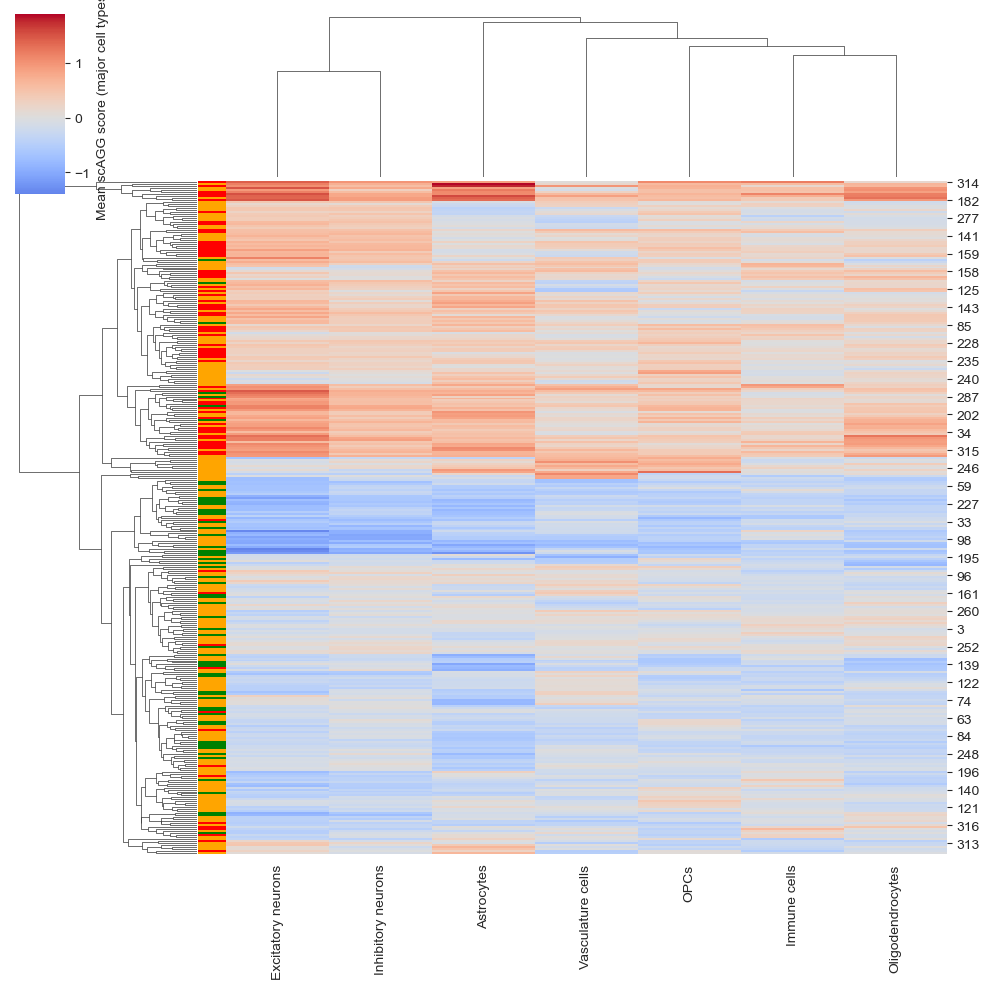

In [152]:
major_filled = mean_ct_score_major.copy()
major_filled[np.isnan(major_filled)] = 0

donor_labels = []
for donor in DONORS:
    label = adata.obs.loc[adata.obs["Donor ID"] == donor, "Label"].values[0]
    donor_labels.append(label)
    
# map to colors for row_colors
donor_labels = pd.Series(donor_labels).map({
    "AD": "red",
    "CT": "green",
    "Other": "orange",
}).values


sns.clustermap(
    major_filled,
    xticklabels=xticks_major,
    # yticklabels=donors_with_prs[np.argsort(donor_y)],
    cmap="coolwarm",
    center=0,
    cbar_kws={"label": "Mean scAGG score (major cell types)"},
    # annot=True,
    # fmt=".2f",
    col_cluster=True,
    row_cluster=True,
    row_colors=donor_labels,
    method="average",
)

c:\Users\timov\Repositories\scAGG\.pixi\envs\default\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
c:\Users\timov\Repositories\scAGG\.pixi\envs\default\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


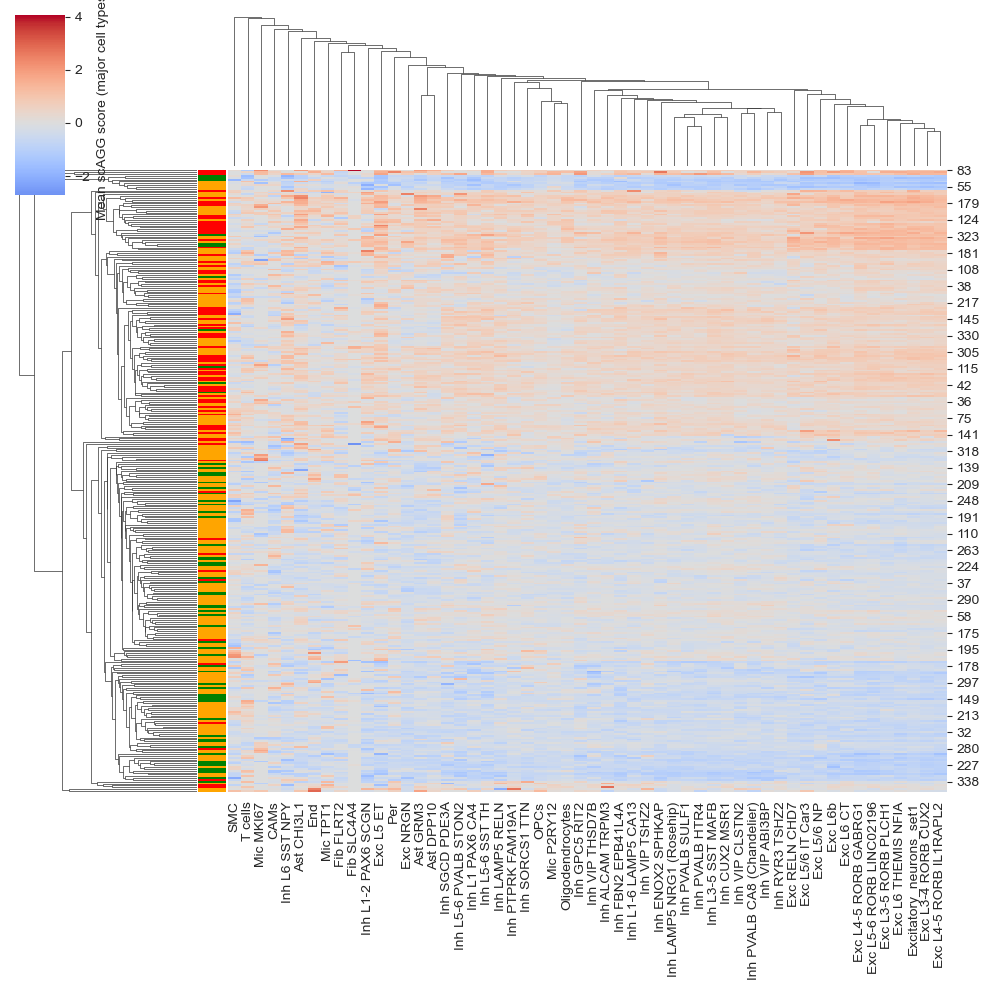

In [155]:
minor_filled = mean_ct_score_minor.copy()
minor_filled[np.isnan(minor_filled)] = 0

donor_labels = []
for donor in DONORS:
    label = adata.obs.loc[adata.obs["Donor ID"] == donor, "Label"].values[0]
    donor_labels.append(label)
    
# map to colors for row_colors
donor_labels = pd.Series(donor_labels).map({
    "AD": "red",
    "CT": "green",
    "Other": "orange",
}).values


sns.clustermap(
    minor_filled,
    xticklabels=xticks_minor,
    # yticklabels=donors_with_prs[np.argsort(donor_y)],
    cmap="coolwarm",
    center=0,
    cbar_kws={"label": "Mean scAGG score (major cell types)"},
    # annot=True,
    # fmt=".2f",
    col_cluster=True,
    row_cluster=True,
    row_colors=donor_labels,
    method="average",
)

C:\Users\timov\AppData\Local\Temp\ipykernel_52884\698082778.py:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(major_pca[:, 0], major_pca[:, 1], c=donor_labels, cmap="coolwarm", alpha=0.7)


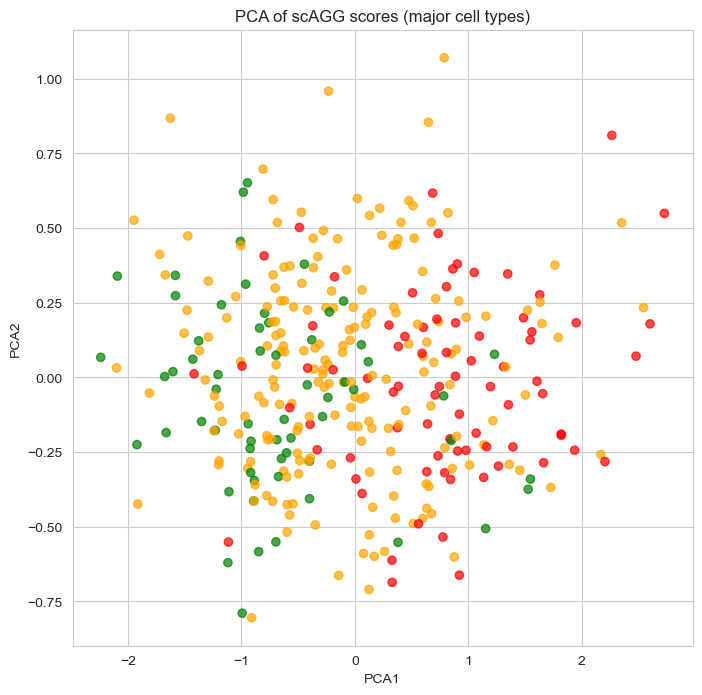

c:\Users\timov\Repositories\scAGG\.pixi\envs\default\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\timov\Repositories\scAGG\.pixi\envs\default\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\timov\AppData\Local\Temp\ipykernel_52884\698082778.py:22: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(umap_major[:, 0], umap_major[:, 1], c=donor_labels, cmap="coolwarm", alpha=0.7)


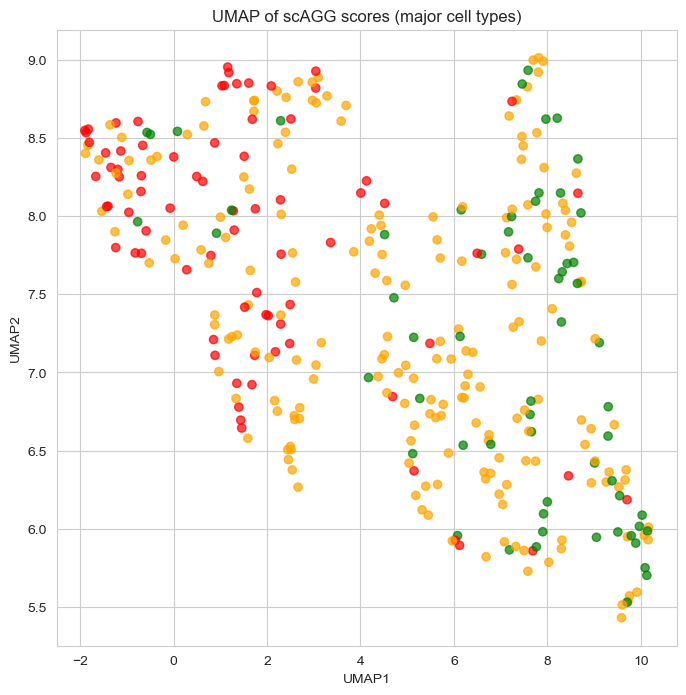

In [ ]:
major_pca = PCA(n_components=2).fit_transform(major_filled)

plt.figure(figsize=(8, 8))
plt.scatter(major_pca[:, 0], major_pca[:, 1], c=donor_labels, cmap="coolwarm", alpha=0.7)
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.title("PCA of scAGG scores (major cell types)")
plt.show()

from umap import UMAP
umap_major = UMAP(n_components=2, random_state=42).fit_transform(major_filled)
plt.figure(figsize=(8, 8))
plt.scatter(umap_major[:, 0], umap_major[:, 1], c=donor_labels, cmap="coolwarm", alpha=0.7)
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.title("UMAP of scAGG scores (major cell types)")
plt.show()



C:\Users\timov\AppData\Local\Temp\ipykernel_52884\3104600851.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(minor_pca[:, 0], minor_pca[:, 1], c=donor_labels, cmap="coolwarm", alpha=0.7)


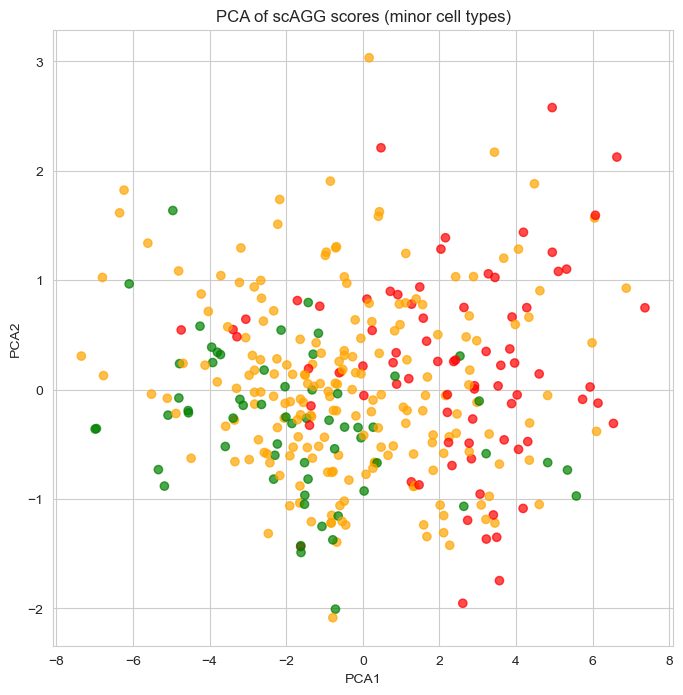

c:\Users\timov\Repositories\scAGG\.pixi\envs\default\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\timov\Repositories\scAGG\.pixi\envs\default\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\timov\AppData\Local\Temp\ipykernel_52884\3104600851.py:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(umap_minor[:, 0], umap_minor[:, 1], c=donor_labels, cmap="coolwarm", alpha=0.7)


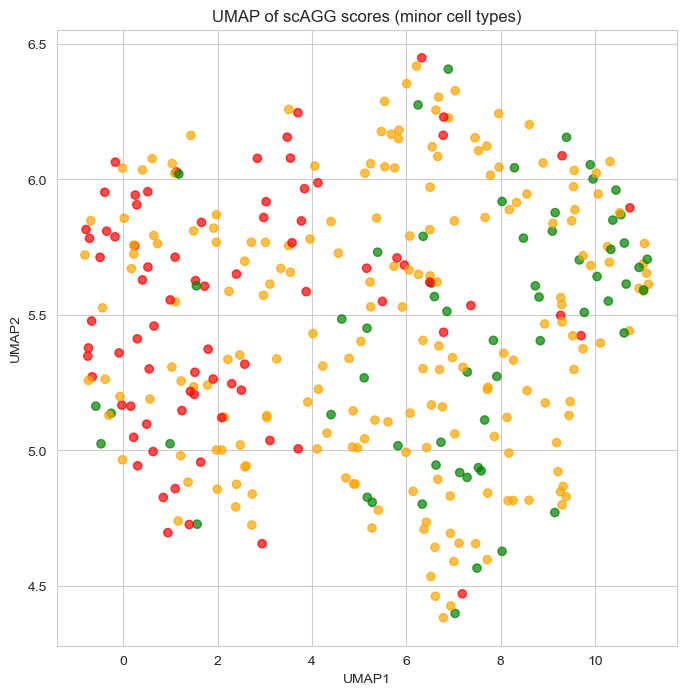

In [156]:

# do the same for minor cell types
minor_pca = PCA(n_components=2).fit_transform(minor_filled)
plt.figure(figsize=(8, 8))
plt.scatter(minor_pca[:, 0], minor_pca[:, 1], c=donor_labels, cmap="coolwarm", alpha=0.7)
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.title("PCA of scAGG scores (minor cell types)")
plt.show()

umap_minor = UMAP(n_components=2, random_state=42).fit_transform(minor_filled)
plt.figure(figsize=(8, 8))
plt.scatter(umap_minor[:, 0], umap_minor[:, 1], c=donor_labels, cmap="coolwarm", alpha=0.7)
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.title("UMAP of scAGG scores (minor cell types)")
plt.show()
